In [1]:
import numpy as np
import os
import pandas as pd
import itertools
from PIL import Image
import seaborn as sns
import fitsio
import skimage.io
import galsim

from astrometry.util.fits import fits_table, merge_tables


# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
#%matplotlib inline
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

In [2]:
def readImage(fn,jpeg=False,ext=1):
    """Reads FITS and jpeg images so that x,y indices refer to the same pixels
    regardless of image format. x,y and fits correspond so the jpeg is rotated and flipped 
    to align with fits
    
    Args:
        fn: image filename
        jpeg: bool, is is a jpeg?
    """
    if jpeg:
        img= skimage.io.imread(fn)
        for i in range(3):
            img[:,:,i]= np.rot90(img[:,:,i].T,1)
    else:
        img= fitsio.FITS(fn)[ext].read()
    return img

def sliceImage(img,
               xslice=slice(None,None),yslice=slice(None,None)):
    """Not sure why, but simcat.x[xslice],simcat.y[yslice]
    corresponds to img[yslice,xslice], eg inverted for the image"""
    return img[yslice,xslice,...]

class plotImage(object):
    """Helper functions for displaying image and overlaying circles around sources
    
    Args:
        img: need to give as initial input b/c some helper funcs that dont directly
            use img, need its shape at least, see circles()
    """
    def imshow(self,img,ax,qs=[0.5,99.5]):
        if img.shape[-1] == 3:
            #minmax=np.percentile(np.sum(img,axis=2),q=qs)
            minmax=[None,None]
            cmap=None
        elif qs is None:
            minmax=[None,None]
            cmap='gray'
        else:
            minmax=np.percentile(img,q=qs)
            cmap='gray'
        ax.imshow(img, interpolation='none', origin='lower',
                  cmap=cmap,vmin=minmax[0],vmax=minmax[1])
        ax.tick_params(direction='out')
        
    def circles(self,xs,ys,ax,
                img_shape=None,
                xslice=None,yslice=None,
                r_pixels=5./0.262,color='y'):
        """
        xs,ys: x,y positions of sources in pixels, e.g. tractor.bx or simcat.x
        img_shape: needed when xslice or yslice is None
        xlice,yslice: slice() objects into the image array
        r_pixels: radius circles in pixels
        """
        if (xslice is None) | (yslice is None):
            assert(not img_shape is None)
        if xslice is None:
            xslice= slice(0,img_shape[0])
        if yslice is None:
            yslice= slice(0,img_shape[1])
        keep= self.justInSlice(xs,ys,xslice,yslice)
        xpos,ypos= xs[keep]-xslice.start,ys[keep]-yslice.start
        
        from matplotlib.patches import Circle,Wedge
        from matplotlib.collections import PatchCollection
        dr= r_pixels/ 20 
        patches=[Wedge((x, y), r_pixels + dr, 0, 360,dr)
                 for x,y in zip(xpos, ypos) ]
        coll = PatchCollection(patches, color=color) #,alpha=1)
        ax.add_collection(coll)
        
    def justInSlice(self,x,y,xslice,yslice):
        """Returns bool array of x,y positions in the slice()"""
        return ((x >= xslice.start) & 
               (x <= xslice.stop) &
               (y >= yslice.start) & 
               (y <= yslice.stop))

# testcase_DR_z

In [3]:
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_z/elg/174/1741p242/rs0/')
IN_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'testcase_DR5_z/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-1741p242.fits'))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-1741p242.fits'))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-1741p242.fits.gz'))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-image.jpg'),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-model.jpg'),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-resid.jpg'),
                     jpeg=True)
                            

In [4]:
len(simcat),len(obitractor),blobs.shape

(4, 3, (200, 200))

<IPython.core.display.Javascript object>


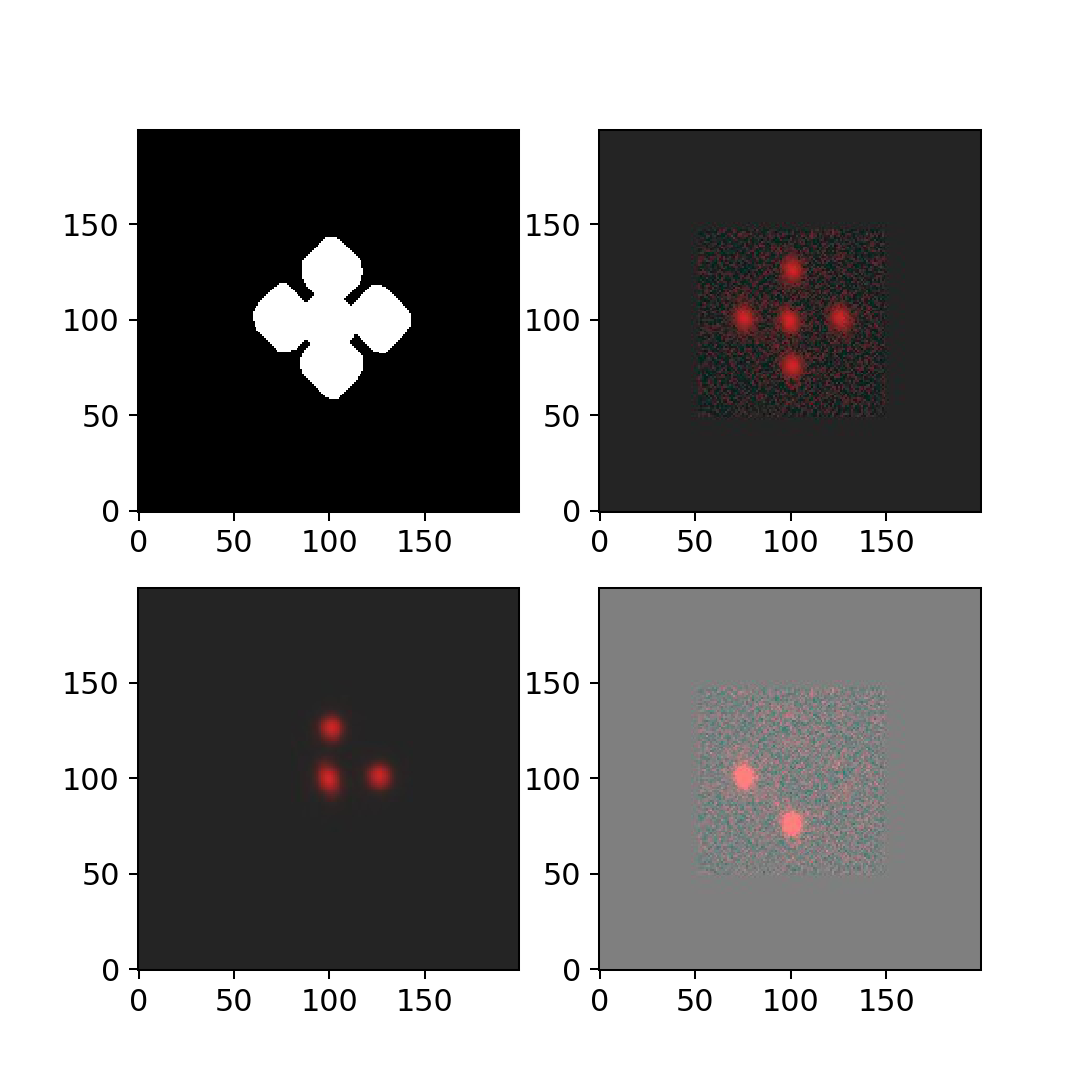

In [5]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg,ax[1,1],qs=None)

# testcase_DR_z_allblobs

In [12]:
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_z_allblobs/elg/174/1741p242/rs0/')
IN_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'testcase_DR5_z_allblobs/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-1741p242.fits'))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-1741p242.fits'))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-1741p242.fits.gz'))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-image.jpg'),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-model.jpg'),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-resid.jpg'),
                     jpeg=True)
                            

In [13]:
len(simcat),len(obitractor),blobs.shape

(4, 3, (200, 200))

<IPython.core.display.Javascript object>


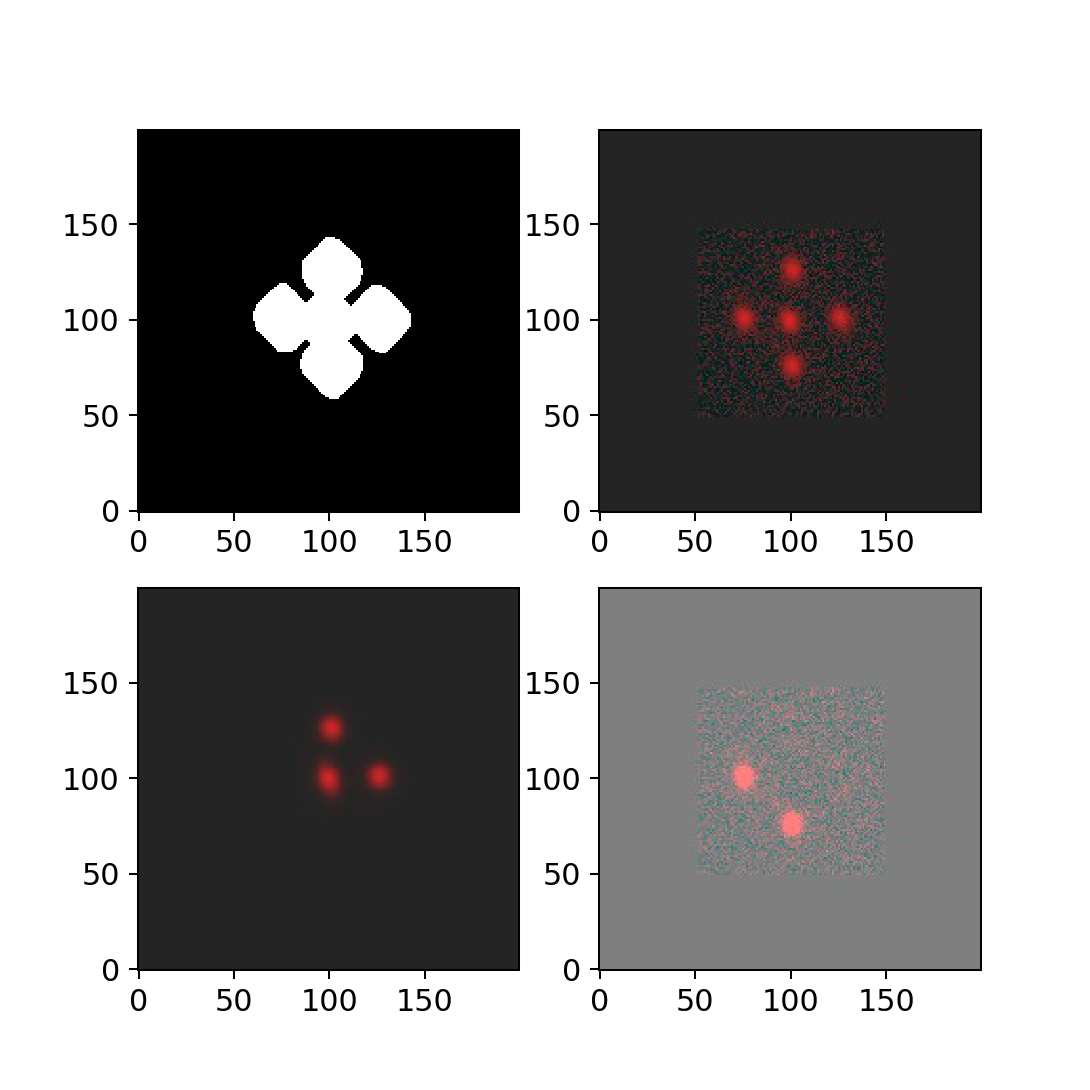

In [14]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg,ax[1,1],qs=None)

# testcase_DR_z_200x200

In [6]:
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_z_200x200/elg/174/1741p242/rs0/')
IN_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'testcase_DR5_z_200x200/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-1741p242.fits'))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-1741p242.fits'))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-1741p242.fits.gz'))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-image.jpg'),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-model.jpg'),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-resid.jpg'),
                     jpeg=True)
                            

In [7]:
len(simcat),len(obitractor),blobs.shape

(4, 4, (200, 200))

<IPython.core.display.Javascript object>


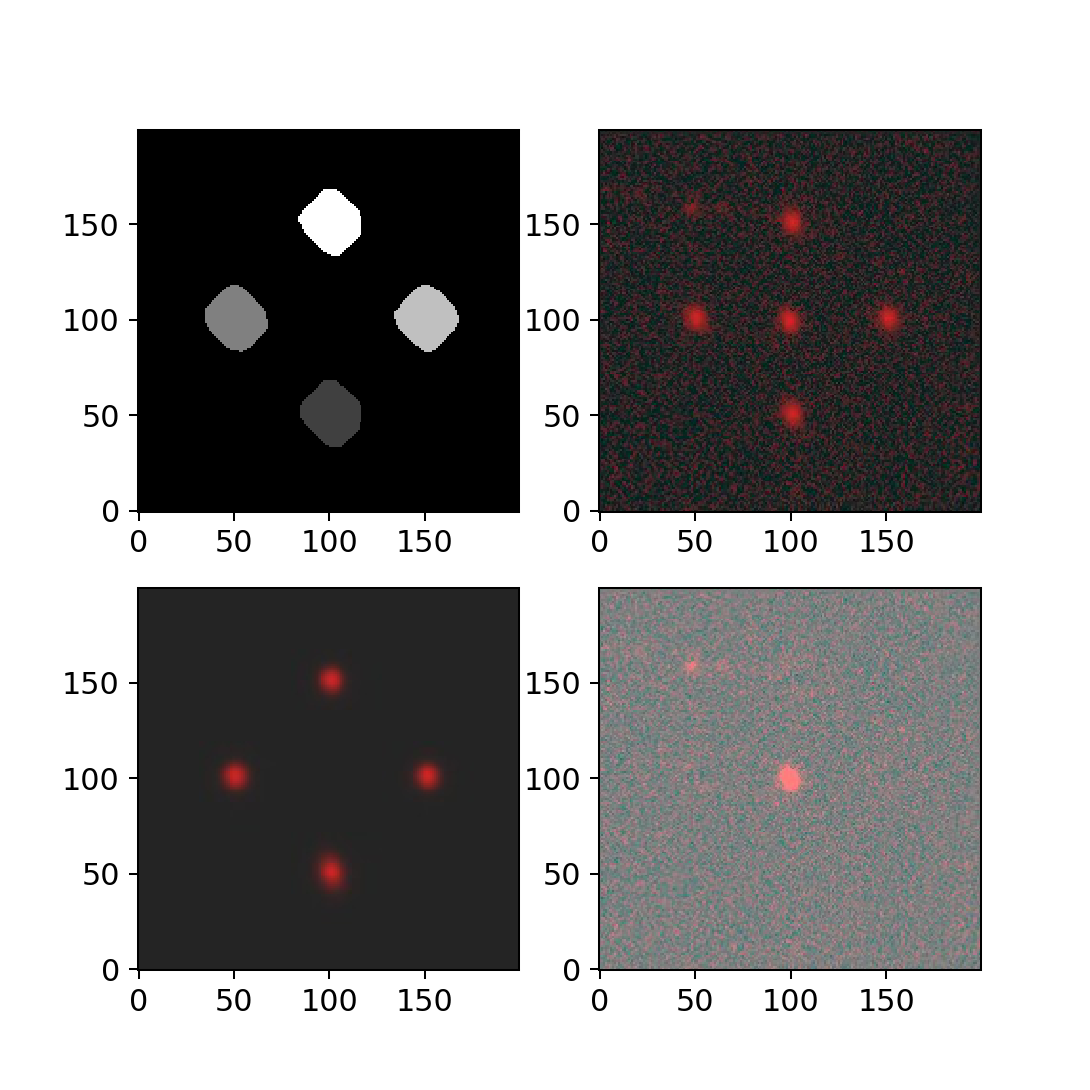

In [8]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg,ax[1,1],qs=None)

# testcase_DR_z_200x200_allblobs

In [9]:
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_z_200x200_allblobs/elg/174/1741p242/rs0/')
IN_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'testcase_DR5_z_200x200_allblobs/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-1741p242.fits'))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-1741p242.fits'))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-1741p242.fits.gz'))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-image.jpg'),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-model.jpg'),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-resid.jpg'),
                     jpeg=True)
                            

In [10]:
len(simcat),len(obitractor),blobs.shape

(4, 7, (200, 200))

<IPython.core.display.Javascript object>


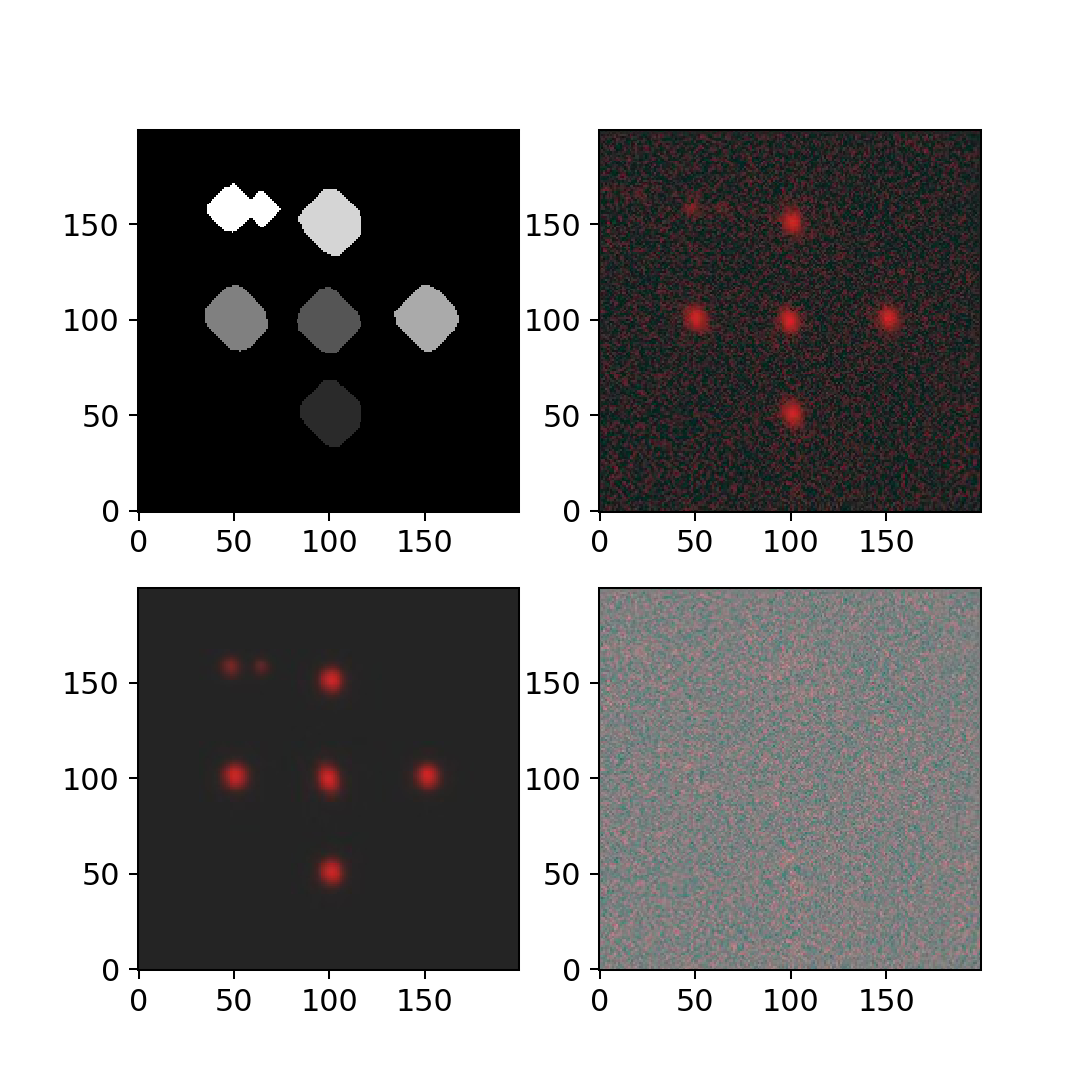

In [11]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg,ax[1,1],qs=None)

In [6]:
!ls $OUT_DIR/tractor/tractor-


brick-1741p242.sha256sum  tractor-1741p242.fits


# What "zoom" is needed for this testcase?

<IPython.core.display.Javascript object>


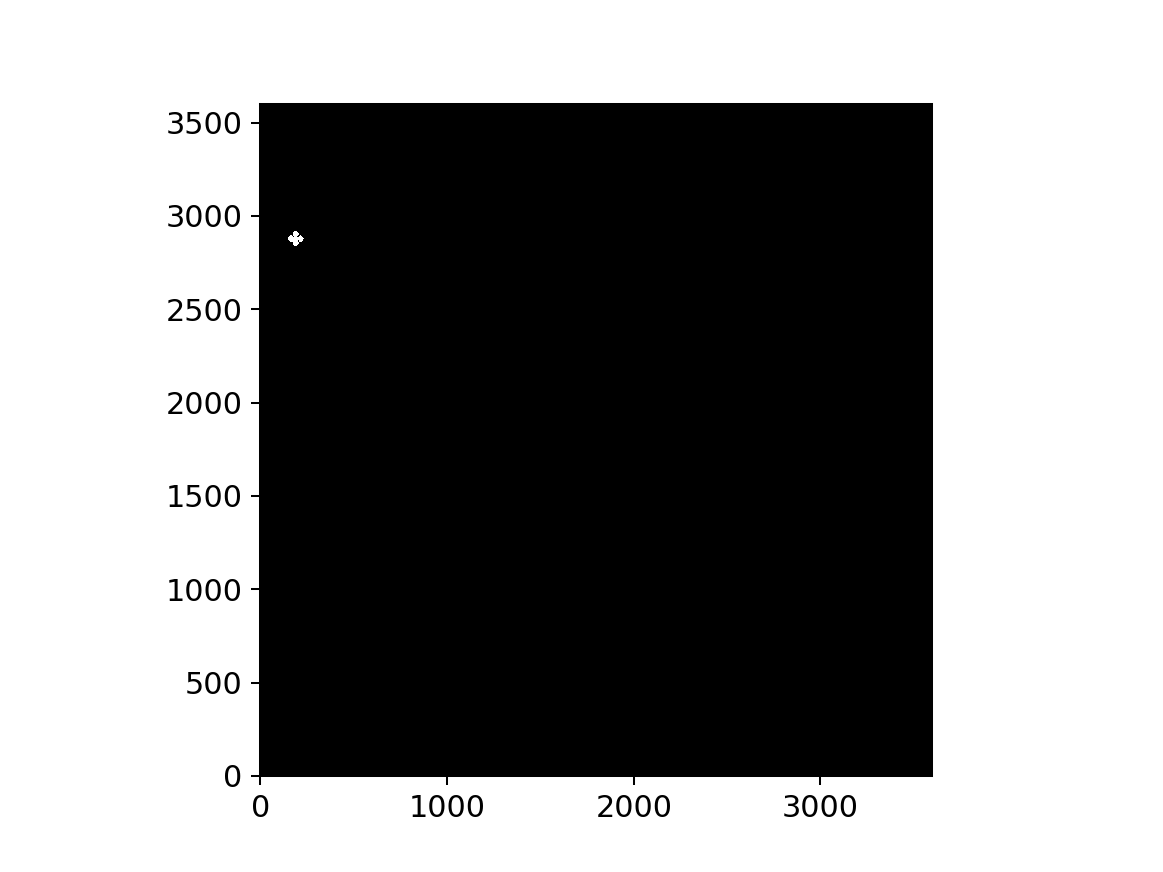

In [22]:
fig,ax=plt.subplots()
plotImage().imshow(blobs,ax,qs=None)

In [27]:
ra=[174.24714700910047, 174.24715333044438, 174.24915898792247, 174.2451413528916]
dec=[24.326224120319477, 24.32988191327332, 24.328050866811363, 24.32805515572893]
np.mean(ra),np.mean(dec)

(174.24715017008975, 24.328053014033273)

In [41]:
os.environ["LEGACY_SURVEY_DIR"]= IN_DIR

from legacypipe.survey import LegacySurveyData, wcs_for_brick
survey = LegacySurveyData()
brickinfo = survey.get_brick_by_name('1741p242')
brickwcs = wcs_for_brick(brickinfo)

AttributeError: 'NoneType' object has no attribute 'ra'

In [28]:
brickwcs.radec2pixelxy(174.24715,24.32805)

(True, 190.26994464884524, 2873.6879080454523)

<IPython.core.display.Javascript object>


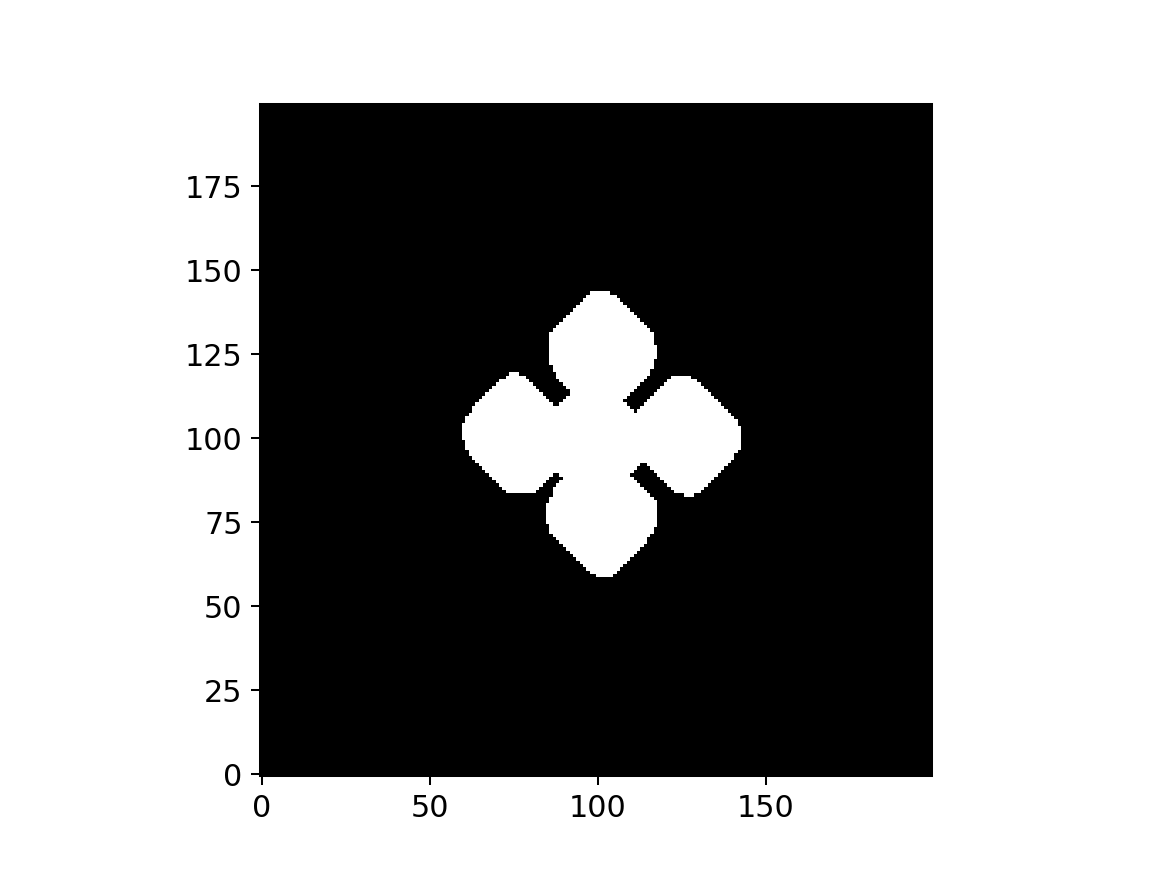

(slice(90, 290, None), slice(2773, 2973, None))


In [38]:
_,x,y= brickwcs.radec2pixelxy(174.2471,24.3262)
x,y= int(x),int(y)+25
hw=100

fig,ax=plt.subplots()
xslc=slice(x-hw,x+hw)
yslc=slice(y-hw,y+hw)
plotImage().imshow(sliceImage(blobs,xslice=xslc,yslice=yslc),
                   ax,qs=None)
print(xslc,yslc)

# Find som isolated sources with 3 bands, make 4 testcases 1 per band and 1 all-band

 1) use viewer to find good source, write down brickname, ra,dec of source and 3 good ccds touching that ra,dec by clicking on the source in the viewer
 
 2) grab the coadd/ccds file for that brick and cut to just those three ccds
 
 3) run create_testcase uses the 3-ccd ccd file
 
 4) put resulting legacysurvydir, tractor catalogue, img jpg, and 3 ccd coadd ccds file on labptop
 
 5) run the cells below 
 
 6) In the end you'll run **create_testcase**. This func needs a ccds file which is the coadd/ccds file with ccd_x0,...,ccd_y1 modified to be the pixel range for each ccd that touches the desired source
 
 7) to get ccd_x0, y1 values use the coadd/ccd table to make a tim objec for each ccd, print out the x,y for the ra,dec of the source using the tim.wcs.wcs.radec2xypixel func
 
 8) modify the ccd_x0,y1 values to be +- 100 pixels of each set of center x,y pixel values

In [43]:
# brick 0285m165, RA,Dec = (28.4194, -16.4362) in viewer looks like good 3 colors source
IN_DIR= os.path.join(os.environ['HOME'],
                     'myrepo/obiwan/tests/end_to_end',
                     'testcase_DR5_grz/')
os.environ["LEGACY_SURVEY_DIR"]= IN_DIR

survey = LegacySurveyData()
brickinfo = survey.get_brick_by_name('0285m165')
brickwcs = wcs_for_brick(brickinfo)

ra,dec= 28.4194, -16.4362
brickwcs.radec2pixelxy(ra,dec)

(True, 3177.4193025452664, 2676.786370753425)

In [67]:
brick='0285m165'
DATA_DIR= os.path.join(os.environ['HOME'],
                       'mydata',brick,'dr5')
dr5tractor= fits_table(os.path.join(DATA_DIR,
                      'tractor-%s.fits' % brick))
#ccds= fits_table(os.path.join(DATA_DIR,
#                 'dr5_3ccds.fits'))
#ccds= fits_table(os.path.join(DATA_DIR,
#                 'ccds_0285m165_dr5coadddir.fits'))
ccds= fits_table(os.path.join(IN_DIR,'survey-ccds-1.fits.gz'))

img_jpg= readImage(os.path.join(DATA_DIR,'legacysurvey-0285m165-image.jpg'),
                   jpeg=True)

<IPython.core.display.Javascript object>


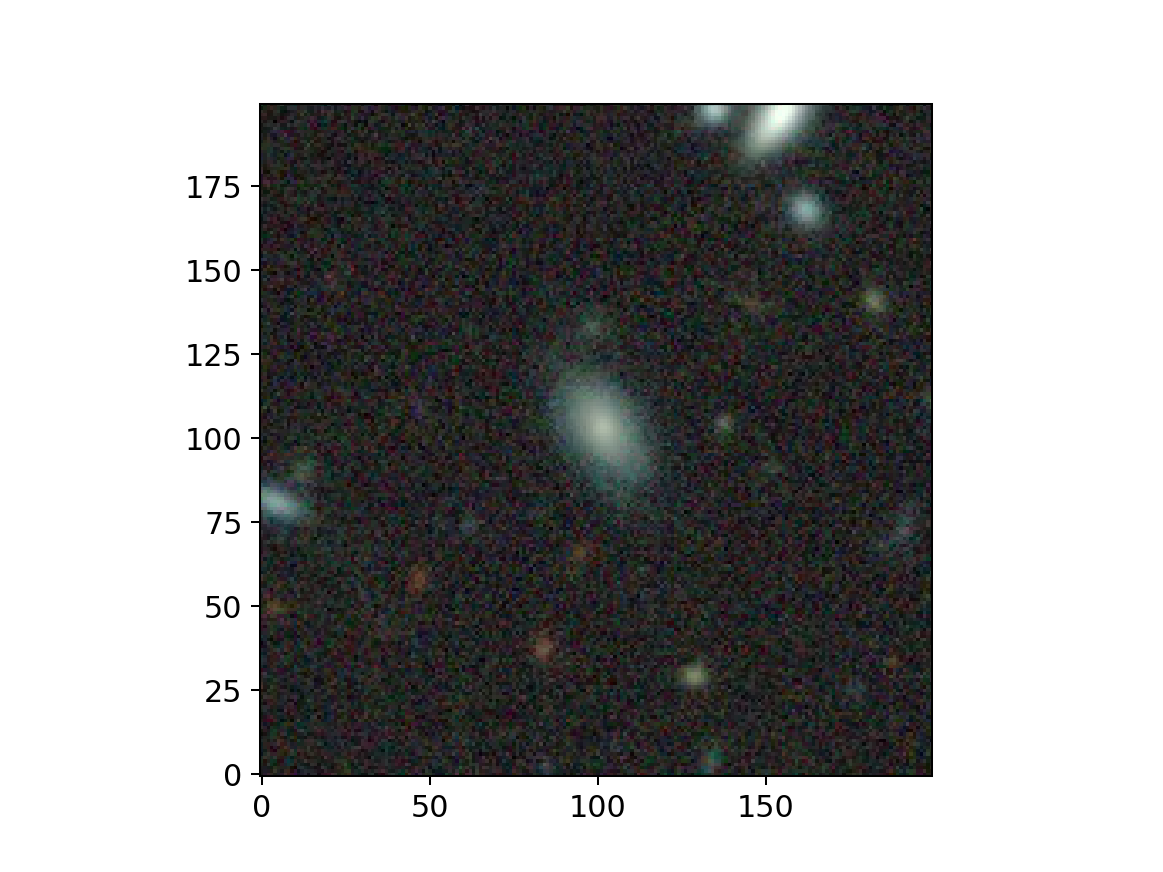

(slice(3077, 3277, None), slice(2576, 2776, None))


In [46]:
_,x,y= brickwcs.radec2pixelxy(ra,dec)
x,y= int(x),int(y)
hw=100

fig,ax=plt.subplots()
xslc=slice(x-hw,x+hw)
yslc=slice(y-hw,y+hw)
plotImage().imshow(sliceImage(img_jpg,xslice=xslc,yslice=yslc),
                   ax,qs=None)
print(xslc,yslc)

In [16]:
from legacypipe.decam import DecamImage
from legacypipe.survey import LegacySurveyData

In [80]:
kwargs = dict(pixPsf=True, splinesky=True, subsky=True, hybridPsf=True,
              pixels=True, dq=True, invvar=True)

survey = LegacySurveyData(ccds=ccds)
tims={}
#for col in ccds.get_columns():
#    if 'S' in str(ccds.get(col).dtype):
#        ccds.set(col,np.char.strip(ccds.get(col)))
for ccd in ccds:
    im = survey.get_image_object(ccd)
    tims[ccd.filter] = im.get_tractor_image(**kwargs)

Reading image slice: None
Reading image from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/images/decam/NonDECaLS/CP20141215/c4d_141206_043719_ooi_z_a1-S10.fits hdu 1
Reading inverse-variance from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/images/decam/NonDECaLS/CP20141215/c4d_141206_043719_oow_z_a1-S10.fits hdu 1
Reading data quality from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/images/decam/NonDECaLS/CP20141215/c4d_141206_043719_ood_z_a1-S10.fits hdu 1
Merged spline sky model does not exist: /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/splinesky-merged/00384/decam-00384128.fits
Reading sky model from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/splinesky/00384/00384128/decam-00384128-S10.fits
Instantiating and subtracting sky model
Merged PsfEx model does not exist: /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/psfex-merged/00384/decam-00384128.fits


In [81]:
tim=tims['g']
tim.wcs.wcs.radec2pixelxy(ra,dec)

(True, 918.0465384893796, 420.42404627704695)

<IPython.core.display.Javascript object>


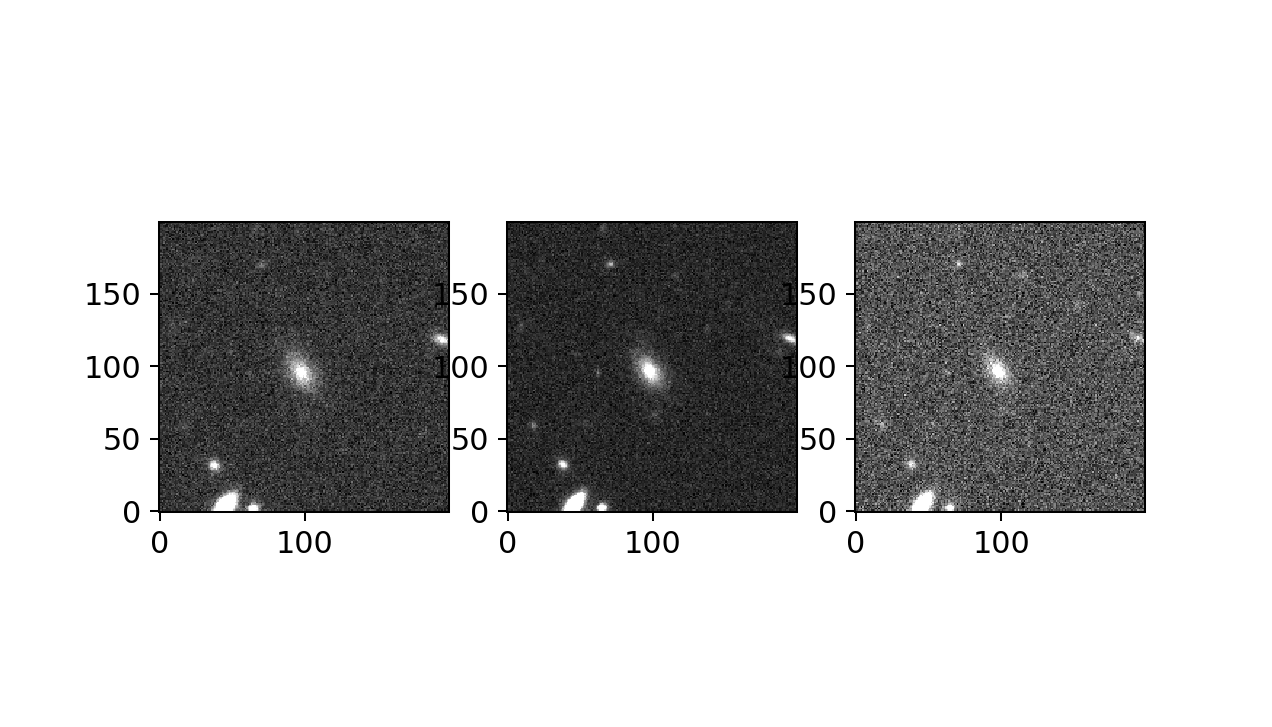

In [82]:
_,x,y= tim.wcs.wcs.radec2pixelxy(ra,dec)
x,y= int(x),int(y)
hw=100
xslc,yslc= slice(x-hw,x+hw),slice(y-hw,y+hw)

fig,ax=plt.subplots(1,3,figsize=(7,4))
for i,band in enumerate(['g','r','z']):
    plotImage().imshow(sliceImage(tims[band].getImage(),xslice=xslc,yslice=yslc).T,
                       ax[i])

<IPython.core.display.Javascript object>


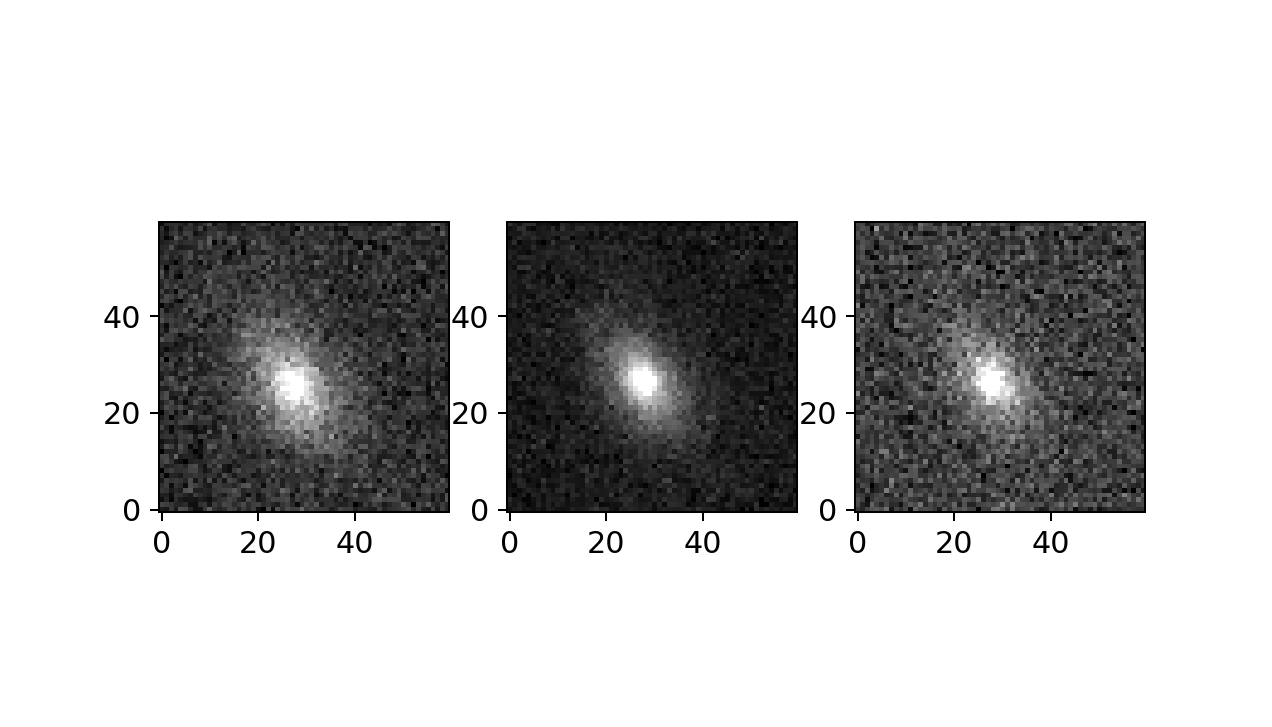

('g', 'nanomags=', 17.956371, 'mags=', 19.364453556756388)
('r', 'nanomags=', 32.756645, 'mags=', 18.711751458105404)
('z', 'nanomags=', 46.451378, 'mags=', 18.332503497939175)


In [87]:
def flux2mag(flux):
    return -2.5*np.log10(1e-9 * flux)

hw=30
xslc,yslc= slice(x-hw,x+hw),slice(y-hw,y+hw)

fig,ax=plt.subplots(1,3,figsize=(7,4))
for i,band in enumerate(['g','r','z']):
    img= sliceImage(tims[band].getImage(),xslice=xslc,yslice=yslc).T
    plotImage().imshow(img,ax[i])
    # Extract the nanomaggie flux for each band that we will add to the images
    print(band,'nanomags=',img.sum(),'mags=',flux2mag(img.sum()))

In [72]:
# flux of this galaxy
from astrometry.libkd.spherematch import match_radec
_,itrac,d= match_radec(np.array([ra]), np.array([dec]), dr5tractor.ra, dr5tractor.dec,          
                        5./3600.0,nearest=True)
itrac

array([4962], dtype=int32)

In [74]:
trac=dr5tractor.copy()
trac.cut(itrac)
len(trac)

1

In [76]:
trac.ra,trac.dec, ra,dec

(array([ 28.4192355]), array([-16.43595489]), 28.4194, -16.4362)

In [88]:
# Tractor measurements on many imags should be close to above values for the three images
for band in ['g','r','z']:
    flux=trac.get('flux_'+band)
    print(band,'nanomags=',flux,'mags=',flux2mag(flux))

('g', 'nanomags=', array([ 16.06177902], dtype=float32), 'mags=', array([ 19.48551559], dtype=float32))
('r', 'nanomags=', array([ 31.8071003], dtype=float32), 'mags=', array([ 18.74369049], dtype=float32))
('z', 'nanomags=', array([ 52.83349609], dtype=float32), 'mags=', array([ 18.19272614], dtype=float32))


In [89]:
trac.ra,trac.dec,trac.type,flux2mag(trac.flux_g),flux2mag(trac.flux_r),flux2mag(trac.flux_z)

(array([ 28.4192355]), array([-16.43595489]), array(['EXP '],
       dtype='|S4'), array([ 19.48551559], dtype=float32), array([ 18.74369049], dtype=float32), array([ 18.19272614], dtype=float32))

In [90]:
trac.shapeexp_r,trac.shapeexp_e1,trac.shapeexp_e2

(array([ 2.4597683], dtype=float32),
 array([ 0.12245165], dtype=float32),
 array([ 0.23880503], dtype=float32))

(28.4194, -16.4362)
[28.423766666666666, 28.415033333333334, 28.4194, 28.4194]
[-16.4362, -16.4362, -16.431833333333334, -16.440566666666665]
[ 918.6980714   918.75985247  859.09916007  978.3570594 ]
[ 477.86830435  363.5315702   420.66734678  420.73262761]


<IPython.core.display.Javascript object>


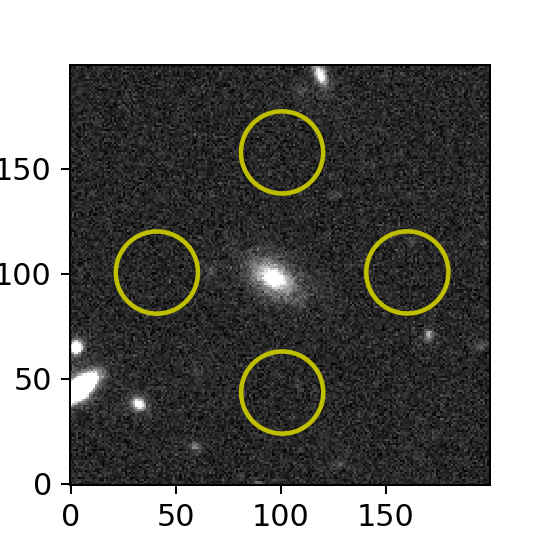

('IMAGE SLICE:', slice(818, 1018, None), slice(320, 520, None))


In [104]:
# Lets circle ra,dec where we'll add galaxies to the r-band image
print(ra,dec)
tim= tims['r']
dd= 60 * 0.262 /3600 # pix*as/pix converted to deg
newra,newdec=[],[]
for dx,dy in zip([dd,-dd,0,0],[0,0,dd,-dd]):
    #newx,newy=x+dx,y+dy
    #ra,dec= tim.wcs.wcs.pixelxy2radec(newx,newy)
    #print(newx,newy,ra,dec)
    newra.append(ra + dx)
    newdec.append(dec + dy)
print(newra)
print(newdec)
_,newx,newy= tim.wcs.wcs.radec2pixelxy(newra,newdec)
print(newx)
print(newy)

_,x,y= tim.wcs.wcs.radec2pixelxy(ra,dec)
x,y= int(x),int(y)
hw=100
xslc,yslc= slice(x-hw,x+hw),slice(y-hw,y+hw)

fig,ax=plt.subplots(figsize=(3,3))
plotImage().imshow(sliceImage(tims['r'].getImage(),xslice=xslc,yslice=yslc),
                   ax)
# cirlces
plotImage().circles(newx,newy,ax,
                    xslice=xslc,yslice=yslc,
                    r_pixels=5./0.262,color='y')
print('IMAGE SLICE:',xslc,yslc)

## Now find ccd_x0, ..., ccd_y1 for each ccd

In [125]:
# start with coadd/ccds
ccds= fits_table(os.path.join(DATA_DIR,
                 'ccds_0285m165_dr5coadddir.fits'))

In [111]:
kwargs = dict(pixPsf=True, splinesky=True, subsky=True, hybridPsf=True,
              pixels=True, dq=False, invvar=False)


survey = LegacySurveyData(ccds=ccds)
vals=[]
for band in ['g','r','z']:
    t= ccds[ccds.filter == band]
    for ccd in t:
        im = survey.get_image_object(ccd)
        tim = im.get_tractor_image(**kwargs)
        _,x,y= tim.wcs.wcs.radec2pixelxy(ra,dec)
        print(band,int(x),int(y))
        vals.append( (band,int(x),int(y)) )

Reading image slice: None
Reading image from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/images/decam/NonDECaLS/CP20141215/c4d_141223_020302_ooi_g_a1.fits.fz hdu 20
Merged spline sky model does not exist: /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/splinesky-merged/00390/decam-00390498.fits
Reading sky model from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/splinesky/00390/00390498/decam-00390498-S10.fits
Instantiating and subtracting sky model
sig1 estimate: 0.00575166300675
Merged PsfEx model does not exist: /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/psfex-merged/00390/decam-00390498.fits
Reading PsfEx model from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/psfex/00390/00390498/decam-00390498-S10.fits
Using PSF model HybridPixelizedPSF: Gaussian sigma 2.10, Pix PixelizedPsfEx
-- creating constant PSF model for norms...
PSF norm: 0.123362
Galaxy norm 0.09

In [114]:
print(vals)
dx=100
from collections import defaultdict
x0,x1,y0,y1= defaultdict(list),defaultdict(list),defaultdict(list),defaultdict(list)
for b,xc,yc in vals:
    x0[b] += [=xc-100,xc+100,yc-100,yc+100)

[('g', 1814, 3205), ('r', 1783, 3215), ('z', 1782, 3263)]
('g', 1714, 1914, 3105, 3305)
('r', 1683, 1883, 3115, 3315)
('z', 1682, 1882, 3163, 3363)


In [122]:
IN_DIR= os.path.join(os.environ['HOME'],
                     'myrepo/obiwan/tests/end_to_end',
                     'testcase_DR5_grz_200x200/')
g=fitsio.FITS(os.path.join(IN_DIR,'images/decam/NonDECaLS/CP20141215/',
                             'c4d_141223_020302_ooi_g_a1-S10.fits'))[1].read()
r=fitsio.FITS(os.path.join(IN_DIR,'images/decam/NonDECaLS/CP20141215/',
                             'c4d_141224_033245_ooi_r_a1-S10.fits'))[1].read()
z=fitsio.FITS(os.path.join(IN_DIR,'images/decam/NonDECaLS/CP20141215/',
                             'c4d_141206_043719_ooi_z_a1-S10.fits'))[1].read()
g.shape

(200, 200)

<IPython.core.display.Javascript object>


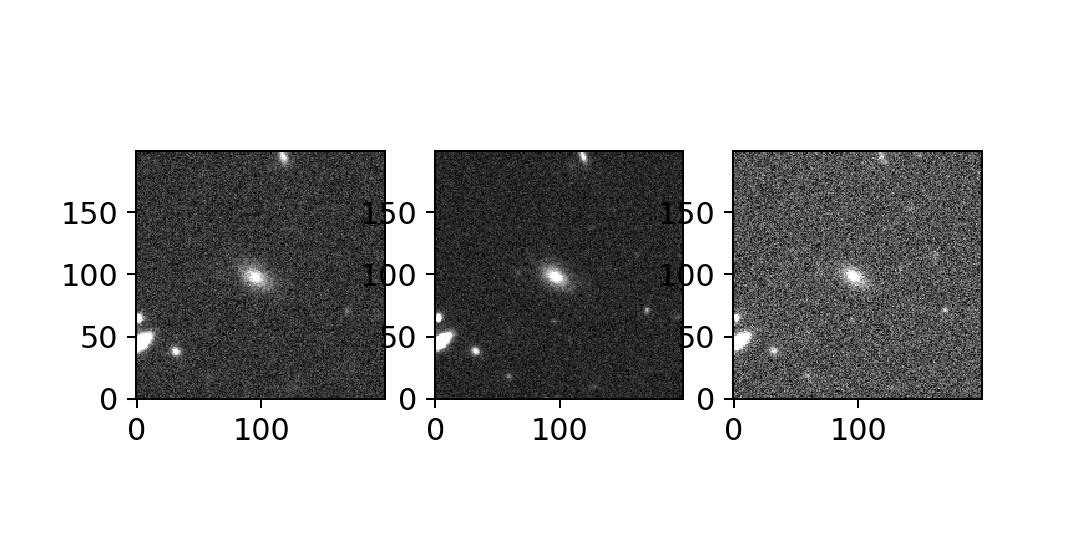

In [123]:
fig,ax=plt.subplots(1,3,figsize=(6,3))
plotImage().imshow(g,ax[0])
plotImage().imshow(r,ax[1])
plotImage().imshow(z,ax[2])

It worked!